In [114]:
# Importy
import pandas as pd
import numpy as np
import pm4py
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from pm4py import discover_bpmn_inductive
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

In [115]:
log = xes_importer.apply('logi/exercise6.xes')

parsing log, completed traces ::   0%|          | 0/132 [00:00<?, ?it/s]

In [116]:
df = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)

In [117]:
df.head()

,org:resource,time:timestamp,concept:name,lifecycle:transition,case:concept:name
0,Call Centre Agent,2005-12-31 23:00:00+00:00,check if sufficient information is available,start,0
1,Call Centre Agent,2006-01-13 23:00:00+00:00,check if sufficient information is available,complete,0
2,Call Centre Agent,2006-01-13 23:00:00+00:00,register claim,start,0
3,Call Centre Agent,2008-01-29 23:00:00+00:00,register claim,complete,0
4,Claims handler,2008-01-29 23:00:00+00:00,determine likelihood of claim,start,0


In [118]:
print(df.groupby(['lifecycle:transition'])['lifecycle:transition'].count())

lifecycle:transition
complete    821
start       821
Name: lifecycle:transition, dtype: int64


In [119]:
df['start_timestamp'] = df.loc[df['lifecycle:transition'] == 'start', 'time:timestamp']
df['complete_timestamp'] = df.loc[df['lifecycle:transition'] == 'complete', 'time:timestamp']
df.drop(['lifecycle:transition', 'time:timestamp'], axis=1, inplace=True)

In [121]:
df.head(5)

,org:resource,concept:name,case:concept:name,start_timestamp,complete_timestamp
0,Call Centre Agent,check if sufficient information is available,0,2005-12-31 23:00:00+00:00,NaT
1,Call Centre Agent,check if sufficient information is available,0,NaT,2006-01-13 23:00:00+00:00
2,Call Centre Agent,register claim,0,2006-01-13 23:00:00+00:00,NaT
3,Call Centre Agent,register claim,0,NaT,2008-01-29 23:00:00+00:00
4,Claims handler,determine likelihood of claim,0,2008-01-29 23:00:00+00:00,NaT


In [122]:
# Grupowanie po pierwszych trzech kolumnach
grouped = df.groupby(['org:resource', 'concept:name', 'case:concept:name'], as_index=False)

# Agregowanie wartości start_timestamp i complete_timestamp za pomocą funkcji first i last
df = grouped.agg({'start_timestamp': 'first', 'complete_timestamp': 'last'})

In [124]:
df.head()

,org:resource,concept:name,case:concept:name,start_timestamp,complete_timestamp
0,Call Centre Agent,check if sufficient information is available,0,2005-12-31 23:00:00+00:00,2006-01-13 23:00:00+00:00
1,Call Centre Agent,check if sufficient information is available,1,2005-12-31 23:00:00+00:00,2006-03-07 23:00:00+00:00
2,Call Centre Agent,check if sufficient information is available,10,2006-03-30 23:00:00+00:00,2006-04-09 23:00:00+00:00
3,Call Centre Agent,check if sufficient information is available,100,2008-07-26 23:00:00+00:00,2008-09-16 23:00:00+00:00
4,Call Centre Agent,check if sufficient information is available,101,2007-11-13 23:00:00+00:00,2008-01-19 23:00:00+00:00


In [149]:
call_centre_agent = df.loc[df['org:resource'] == 'Call Centre Agent']
print(call_centre_agent['concept:name'].unique())

['check if sufficient information is available' 'end' 'register claim']


In [150]:
check_if_sufficient = call_centre_agent.loc[call_centre_agent['concept:name'] == 'check if sufficient information is available']
register_claim = call_centre_agent.loc[call_centre_agent['concept:name'] == 'register claim']
end = call_centre_agent.loc[call_centre_agent['concept:name'] == 'end']

In [151]:
def plot_log_times(df):
    plt.plot(df['start_timestamp'], alpha=0.5, label='Start_date')
    plt.plot(df['complete_timestamp'], alpha=0.5, label='End_date')
    plt.legend()
    plt.show()

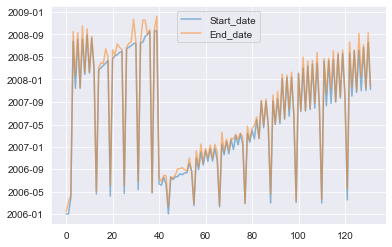

In [154]:
plot_log_times(check_if_sufficient)

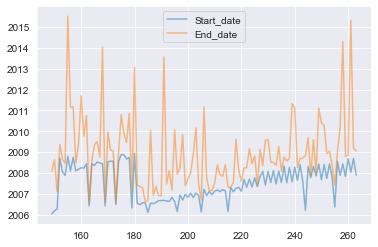

In [156]:
plot_log_times(register_claim)

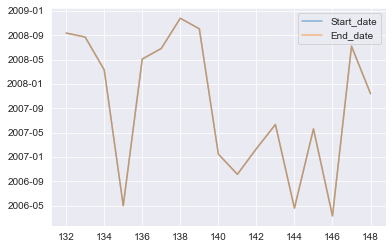

In [157]:
plot_log_times(end)